# Dynamic Price Optimizations

#### **Objective:**

The primary objective of this project is to develop an advanced predictive model that accurately estimates the selling price of products listed on Mercari. By analyzing the relationships between various product features, such as item condition, brand, category, and description, we aim to create a model that enables sellers to determine optimal pricing strategies. This will not only help sellers set competitive prices that increase their chances of making a sale but also equip them with insights into how different factors impact product pricing in the online marketplace.

Moreover, this project holds significant value as it directly addresses the dynamic nature of e-commerce pricing. In an environment where buyers and sellers are constantly competing to find the best deals, a tool that provides reliable price predictions can lead to more informed decision-making. This, in turn, enhances market efficiency by facilitating fairer pricing and improving the overall transaction experience. The ability to predict prices with accuracy could benefit sellers by reducing overpricing or underpricing, while buyers can gain confidence in the value of the products they are purchasing. Additionally, it offers a rich opportunity to explore the application of machine learning in optimizing pricing strategies, making it both an impactful and interesting project in the context of real-world e-commerce.

## Import and Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

import re
import torch
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, explained_variance_score

In [2]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1.) Data Loading


**Data Source & Overview:**
The project will utilize the Mercari Price Suggestion dataset, which is publicly accessible on Kaggle. This dataset is well-structured and comprises a substantial number of entries, fulfilling the necessary requirements for dataset size. The structured nature of the data, combined with its free availability and compliance with legal standards, makes it an appropriate choice for this analysis. The dataset includes various product attributes essential for conducting a comprehensive analysis of pricing dynamics within an e-commerce context.
Mercari, Inc is a Japanese e-commerce company founded in 2013 and their main product, the Mercari marketplace app is Japan's largest community-powered marketplace with over JPY 10 billion in transactions carried out on the platform each month. The dataset is provided by the company.

In [3]:
%%capture
!apt update
!pip install kaggle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!mkdir ~/.kaggle

In [6]:
!cp /content/drive/MyDrive/BDA/PROJECT/kaggle.json ~/.kaggle/

In [7]:
!!kaggle competitions download -c mercari-price-suggestion-challenge

['Downloading mercari-price-suggestion-challenge.zip to /content',
 '',
 '  0% 0.00/403M [00:00<?, ?B/s]',
 '  0% 2.00M/403M [00:00<00:29, 14.2MB/s]',
 '  1% 4.00M/403M [00:00<00:24, 17.2MB/s]',
 '  2% 7.00M/403M [00:00<00:18, 22.9MB/s]',
 '  3% 11.0M/403M [00:00<00:14, 28.9MB/s]',
 '  3% 14.0M/403M [00:00<00:14, 28.9MB/s]',
 '  6% 24.0M/403M [00:00<00:08, 48.9MB/s]',
 '  7% 29.0M/403M [00:00<00:10, 39.0MB/s]',
 '  8% 33.0M/403M [00:01<00:11, 33.4MB/s]',
 '  9% 37.0M/403M [00:01<00:13, 27.6MB/s]',
 ' 12% 49.0M/403M [00:01<00:08, 43.3MB/s]',
 ' 13% 54.0M/403M [00:01<00:08, 42.8MB/s]',
 ' 15% 59.0M/403M [00:01<00:08, 41.7MB/s]',
 ' 16% 66.0M/403M [00:01<00:07, 48.1MB/s]',
 ' 20% 80.0M/403M [00:01<00:04, 71.9MB/s]',
 ' 22% 88.0M/403M [00:02<00:05, 64.3MB/s]',
 ' 24% 95.0M/403M [00:02<00:05, 56.6MB/s]',
 ' 25% 101M/403M [00:02<00:07, 40.1MB/s] ',
 ' 26% 106M/403M [00:02<00:08, 37.9MB/s]',
 ' 30% 121M/403M [00:02<00:05, 55.9MB/s]',
 ' 32% 129M/403M [00:02<00:04, 58.5MB/s]',
 ' 34% 137M/403M

In [8]:
!unzip /content/mercari-price-suggestion-challenge.zip

Archive:  /content/mercari-price-suggestion-challenge.zip
  inflating: sample_submission.csv.7z  
  inflating: sample_submission_stg2.csv.zip  
  inflating: test.tsv.7z             
  inflating: test_stg2.tsv.zip       
  inflating: train.tsv.7z            


In [9]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 2.8 MB/s eta 0:00:00


In [10]:
import patoolib as patool
patool.extract_archive("/content/train.tsv.7z", outdir="/content/")

INFO patool: Extracting /content/train.tsv.7z ...
INFO:patool:Extracting /content/train.tsv.7z ...
INFO patool: running /usr/bin/7z x -aou -o/content/ -- /content/train.tsv.7z
INFO:patool:running /usr/bin/7z x -aou -o/content/ -- /content/train.tsv.7z
INFO patool: ... /content/train.tsv.7z extracted to `/content/'.
INFO:patool:... /content/train.tsv.7z extracted to `/content/'.


'/content/'

In [11]:
patool.extract_archive("/content/test.tsv.7z", outdir="/content/")

INFO patool: Extracting /content/test.tsv.7z ...
INFO:patool:Extracting /content/test.tsv.7z ...
INFO patool: running /usr/bin/7z x -aou -o/content/ -- /content/test.tsv.7z
INFO:patool:running /usr/bin/7z x -aou -o/content/ -- /content/test.tsv.7z
INFO patool: ... /content/test.tsv.7z extracted to `/content/'.
INFO:patool:... /content/test.tsv.7z extracted to `/content/'.


'/content/'

In [12]:
train = pd.read_csv(f'/content/train.tsv', sep='\t')
test = pd.read_csv(f'/content/test.tsv', sep='\t')

### 1.1) Understanding / Overview of Data

In [13]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [14]:
train.shape

(1482535, 8)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [16]:
train.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,6327
brand_name,632682
price,0
shipping,0
item_description,6


In [17]:
#Filling missing values in 'brand_name', 'category_name', and 'item_description' with "Null"
train['brand_name'] = train['brand_name'].fillna(value='Null')
train['category_name'] = train['category_name'].fillna(value='Null')
train['item_description'] = train['item_description'].fillna(value='Null')

train.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0


### 1.2) Data Preprocessing

The dataset contains text fields such as name, item_description, category_name, and brand_name, which need to be standardized and cleaned. The following preprocessing steps are applied:


*   Handle Missing Values: Address missing values in name and item_description by replacing them with 'missing'.

*   Convert Text to Lowercase: Ensure consistency by converting text in name, item_description, and brand_name to lowercase.

* Strip Unnecessary Spaces: Remove leading and trailing spaces from name and item_description.
* Process Special Characters: In category_name, replace characters like "s " with a space and "/" with a space, then convert to lowercase.





In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
st_words = stopwords.words('english')
def cleanText(x: str):
    if (pd.isna(x)):
        return 'missing'
    x = x.lower()
    x = x.strip()
    return x
def cleanCat(x: str):
    if (pd.isna(x)):
        return x
    x = x.replace("s ", " ")
    x = x.replace("s/", "/")
    x = x.replace('/'," ")
    return x.lower()

train['name'] = train.name.apply(cleanText)
train['item_description_clean'] = train.item_description.apply(cleanText)
train['clean_category_name'] = train.category_name.apply(cleanCat)
train['brand_name'] = train.brand_name.apply(lambda x: x if pd.isna(x) else x.lower())

## 2.) Exploratory Data Analysis

### --- 2.1) Target Distribution ---

<Axes: ylabel='Frequency'>

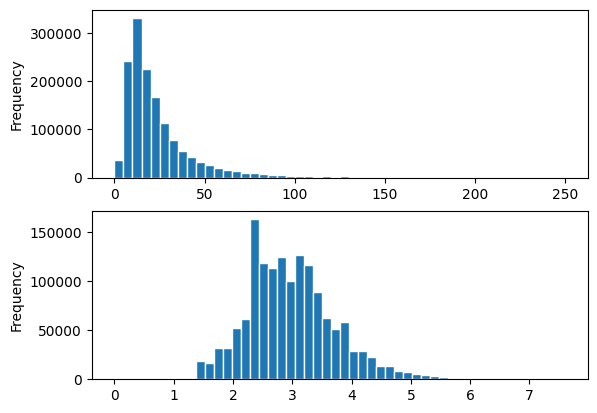

In [20]:
# Plotting the distribution of prices before and after log transformation to visualize skewness
plt.subplot(2,1,1)
train.price.plot.hist(bins=50, edgecolor='white', range=[0,250])
plt.subplot(2,1,2)
np.log(train.price+1).plot.hist(bins=50, edgecolor='white')

In [21]:
train['target_log'] = np.log(train.price+1)

### --- 2.2) Category Analysis ---


In [22]:
# Checking if item is unique
i = train.name.value_counts().size
print ('Number of distinct items names : ', i)

Number of distinct items names :  1139301


In [23]:
# Total number of Categories
i = train.category_name.value_counts().size
print ('Number of distinct categories : ', i)

Number of distinct categories :  1288


<ipython-input-24-7fe60aabc7e5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y = train.category_name, order = train.category_name.value_counts().iloc[:10].index, orient = 'v', palette='rocket')


Text(0.5, 0, 'Number of product in the category')

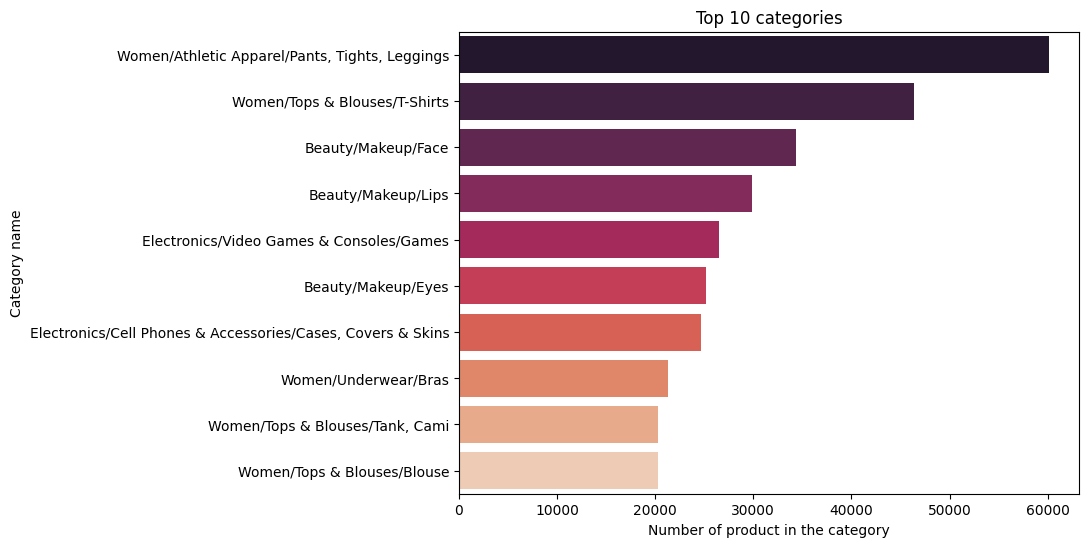

In [24]:
# Plotting the top 10 most frequent categories in the dataset to visualize category distribution
plt.figure(figsize=(8, 6))
sns.countplot(y = train.category_name, order = train.category_name.value_counts().iloc[:10].index, orient = 'v', palette='rocket')
plt.title('Top 10 categories')
plt.ylabel('Category name')
plt.xlabel('Number of product in the category')

The plot reveals that Women/Athletics Pants Tights Leggings is the most frequent product category in the dataset, indicating its dominance in the Mercari marketplace. This suggests that products in this category are highly popular, which could influence pricing patterns and demand.

In [25]:
# Create a DataFrame of category counts, reset the index, and sort by the most frequent categories
categories = pd.DataFrame(train.category_name.value_counts())
categories.reset_index(level = 0, inplace=True)
categories = categories.sort_values(by='category_name', ascending = False).head(20)
categories.columns =('category_name', 'size')

In [26]:
# Group the data by category_name and calculate the mean price for each category
group = train.groupby(train.category_name)
mean_price = group.price.mean()
mean_price = pd.DataFrame(mean_price)
mean_price.reset_index(level = 0, inplace=True)

In [27]:
# Merge the top 20 categories with their respective mean price
categories = pd.merge(categories, mean_price, how='left', on = 'category_name')

In [28]:
categories.head()

,category_name,size,price
0,Women/Women's Handbags/Totes & Shoppers,9373,58.385362
1,Women/Women's Handbags/Shoulder Bag,15328,65.975535
2,Women/Women's Handbags/Satchel,2333,111.624518
3,Women/Women's Handbags/Other,1116,36.949821
4,Women/Women's Handbags/Messenger & Crossbody,8926,58.925723


In [29]:
import matplotlib.colors as mcolors

cmap = plt.get_cmap('rocket')
mini = min(categories['size'])
maxi = max(categories['size'])
norm = mcolors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in categories['size']]

In [30]:
!pip install squarify

(0.0, 100.0, 0.0, 100.0)

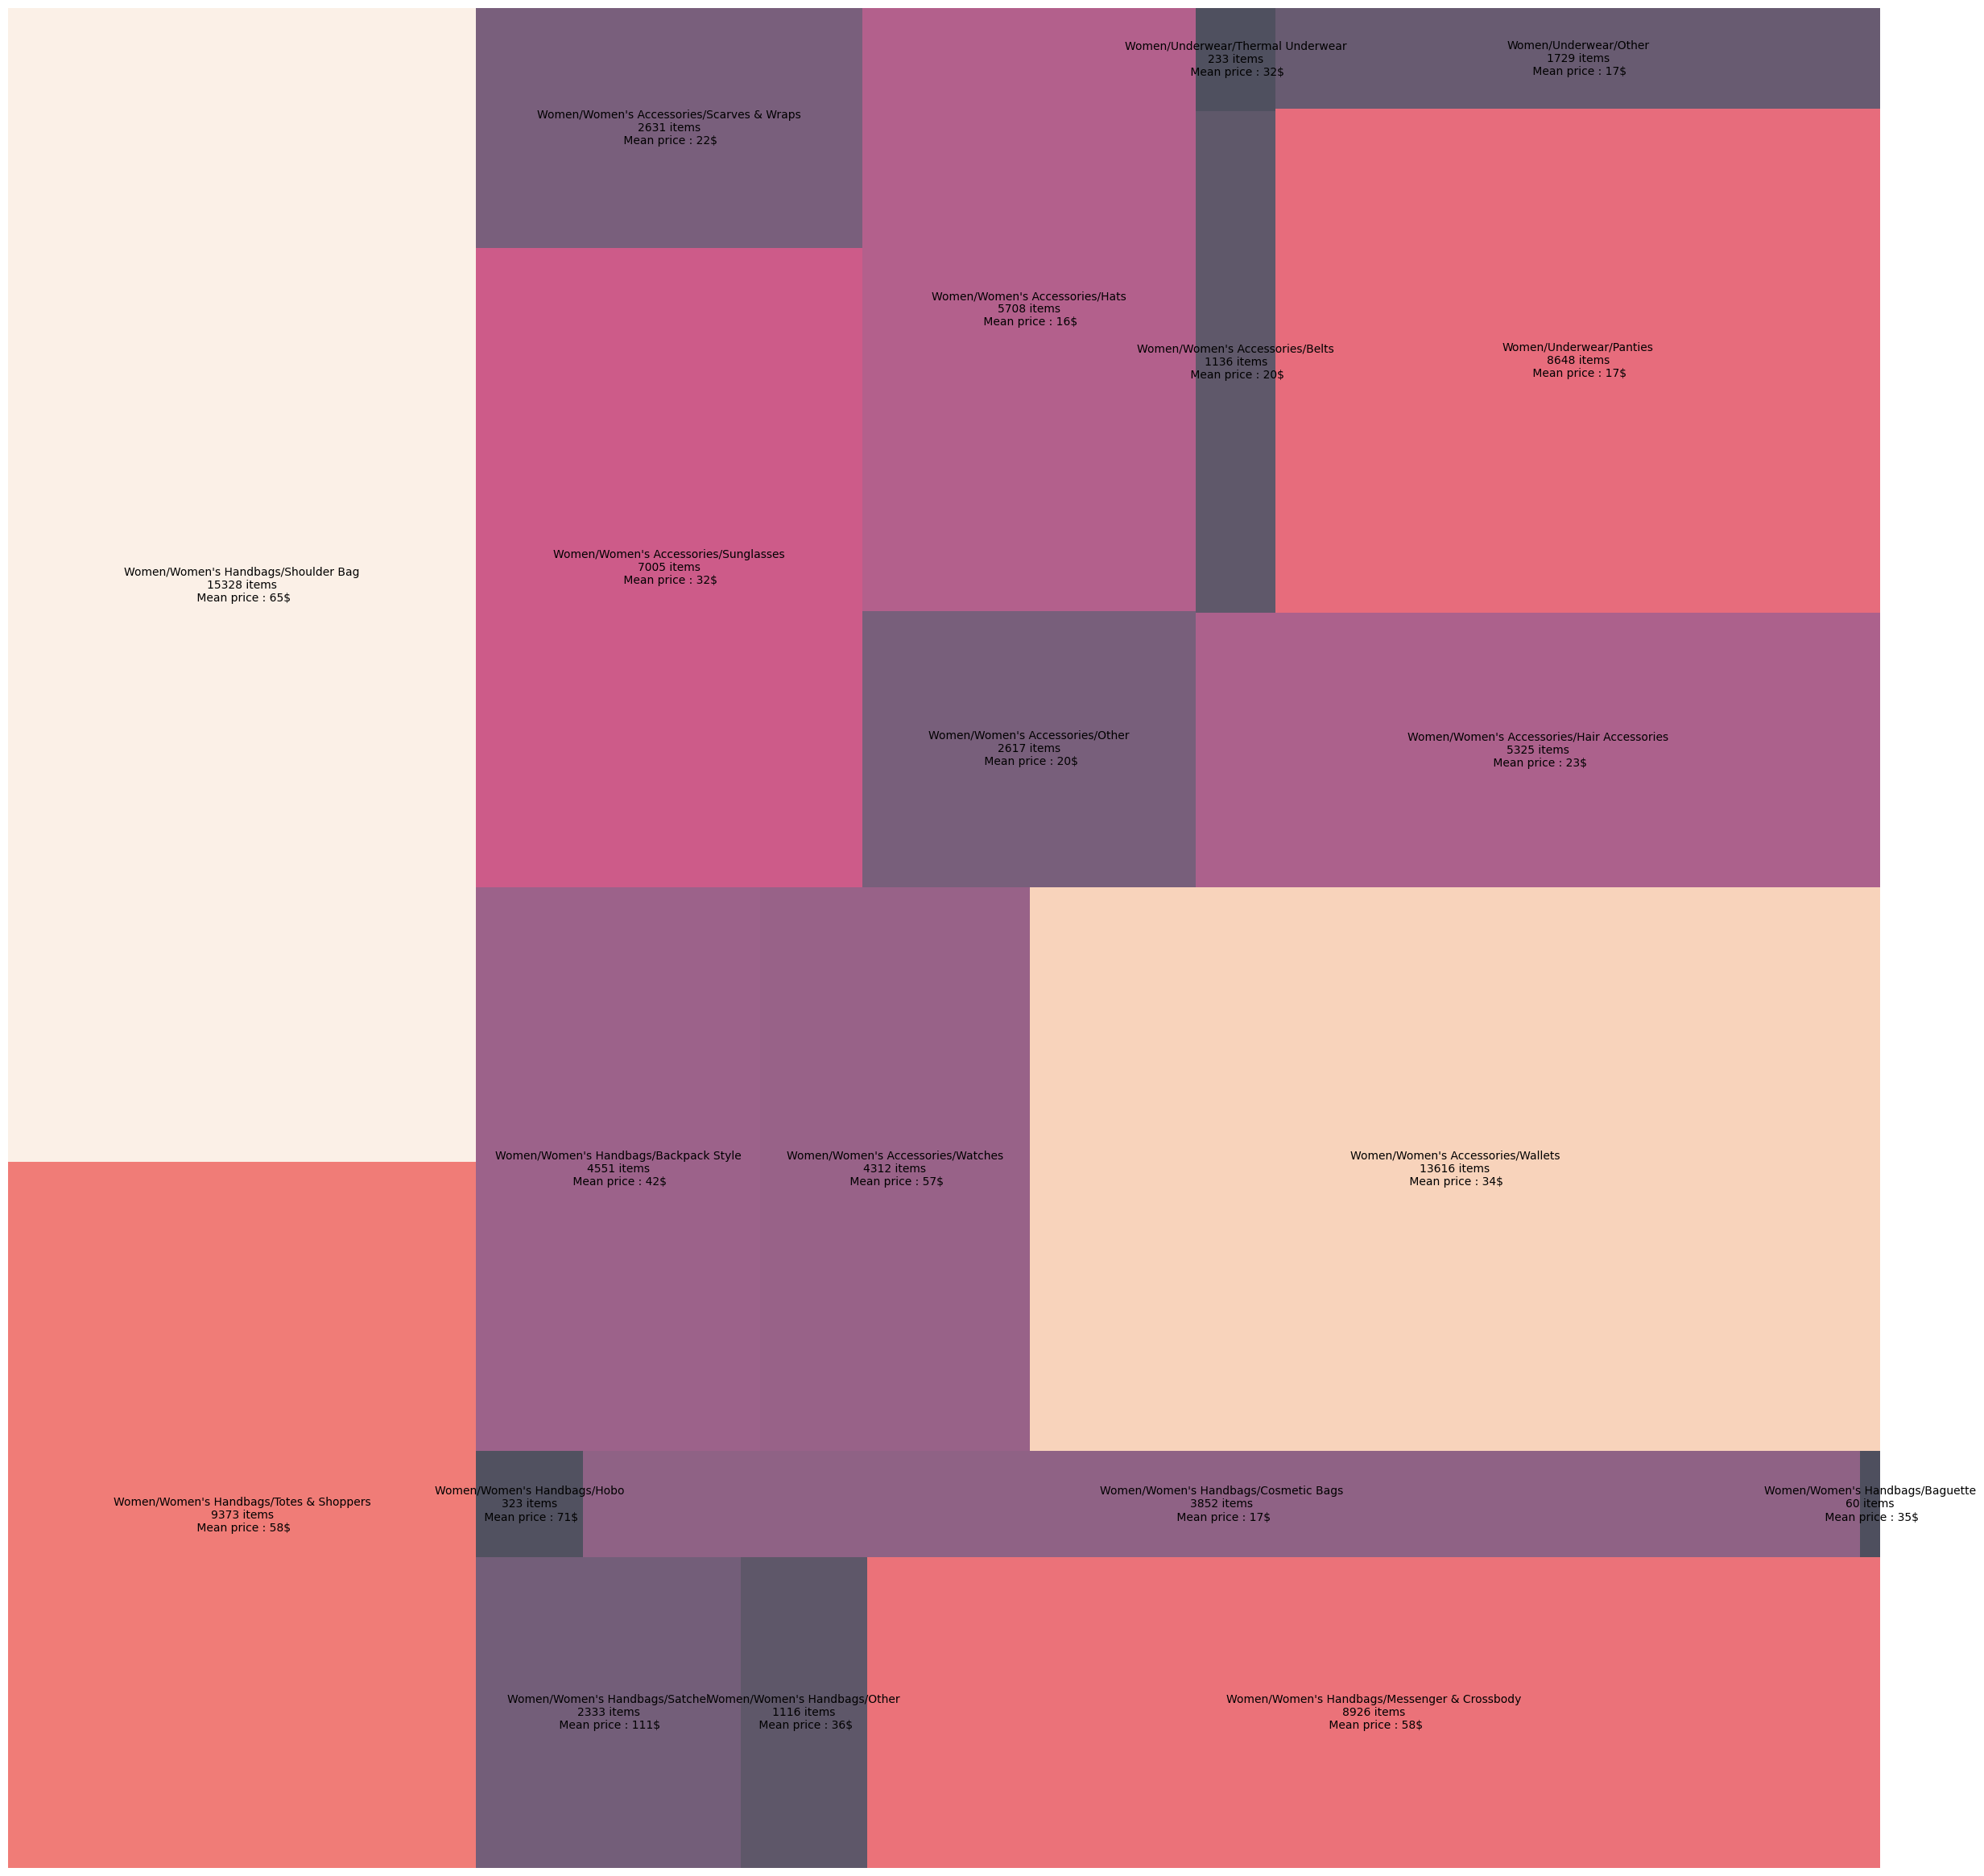

In [31]:
import squarify

labels = ["%s\n%d items\n Mean price : %d$" % (label) for label in zip(categories['category_name'], categories['size'], categories['price'])]

plt.figure(figsize=(30,30))
plt.rc('font', size=10)
squarify.plot(sizes = categories['size'], label= labels, alpha = .7, color=colors)
plt.axis('off')

A heatmap is used here because it provides a clear, visually appealing representation of values, allowing to compare relative sizes and mean prices for each category more easily within a single visual, highlighting trends or clusters.

<ipython-input-32-5179d2ec331a>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'price', y = 'category_name', data = mean_price, orient = 'h', palette='rocket')


Text(0.5, 0, 'Mean price')

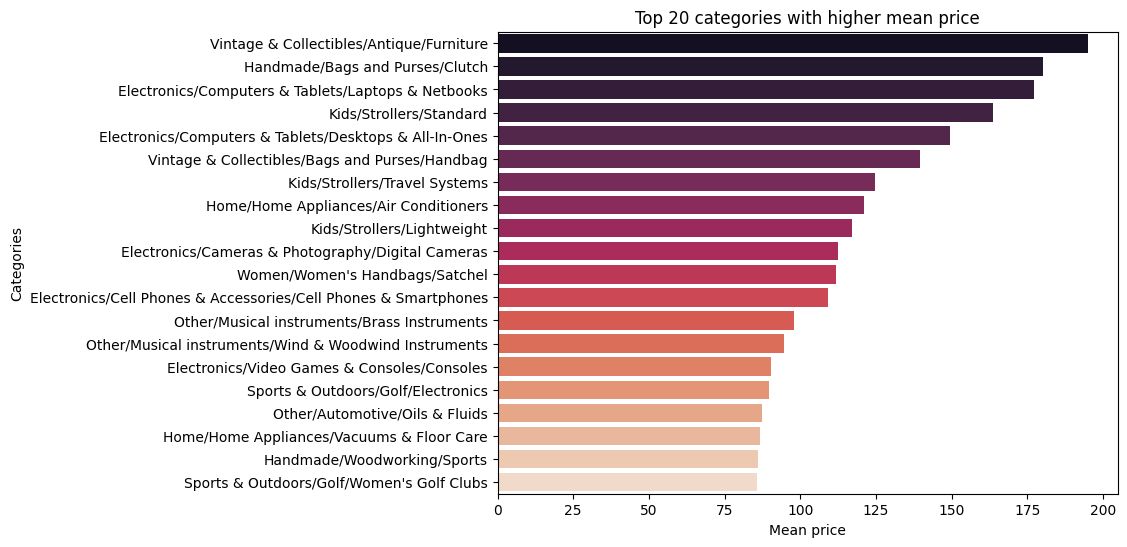

In [32]:
#Visualizing the price variation across top categories
group = train.groupby(train.category_name)
mean_price = pd.DataFrame(group.price.mean())
mean_price = mean_price.sort_values(by='price', ascending = False).head(20)
mean_price.reset_index(level = 0, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(x = 'price', y = 'category_name', data = mean_price, orient = 'h', palette='rocket')
plt.title('Top 20 categories with higher mean price')
plt.ylabel('Categories')
plt.xlabel('Mean price')

Text(0.5, 0, 'Mean price of each category')

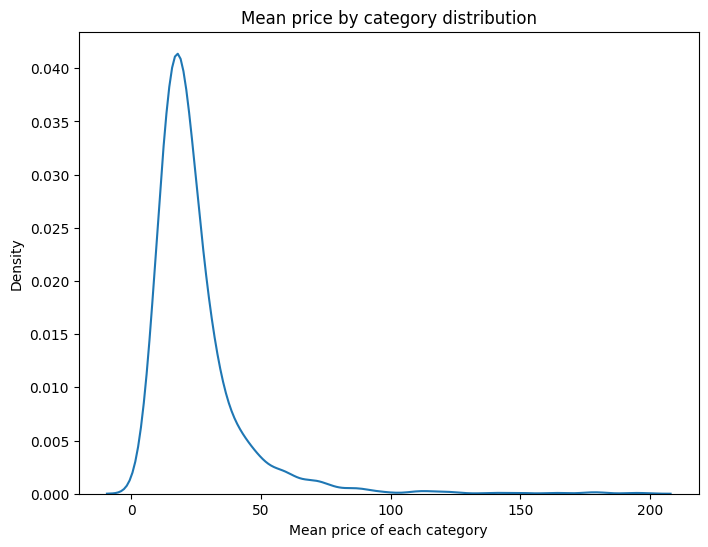

In [33]:
# Checking Mean Price
mean_price = pd.DataFrame(group.price.mean())
mean_price.reset_index(level = 0, inplace=True)

plt.figure(figsize =(8,6))
sns.kdeplot(mean_price.price)
plt.title('Mean price by category distribution')
plt.xlabel('Mean price of each category')

 Most of the categories have cheap items less than 50 hence split

#### 2.2.1) Splitting Categories

In [34]:
train['cat_split_count'] = train.category_name.apply(lambda x: x if pd.isna(x) else len(x.split('/')))

The code splits the category_name into three new columns: general_cat, sub_cat1, and sub_cat2. It extracts the first, second, and third parts of the category_name (separated by '/') and assigns them to the respective columns. If a part doesn’t exist, it assigns NaN. This process helps to break down the category into more granular levels.

In [35]:
train['general_cat'] = train.category_name.apply(lambda x: x if pd.isna(x) else (x.split('/')[0] if len(x.split('/')) > 0 else None))
train['sub_cat1'] = train.category_name.apply(lambda x: x if pd.isna(x) else (x.split('/')[1] if len(x.split('/')) > 1 else None))
train['sub_cat2'] = train.category_name.apply(lambda x: x if pd.isna(x) else (x.split('/')[2] if len(x.split('/')) > 2 else None))

In [36]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,item_description_clean,clean_category_name,target_log,cat_split_count,general_cat,sub_cat1,sub_cat2
0,0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,null,10.0,1,No description yet,no description yet,men top t-shirts,2.397895,3,Men,Tops,T-shirts
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,razer,52.0,0,This keyboard is in great condition and works ...,this keyboard is in great condition and works ...,electronic computer & tablet component & parts,3.970292,3,Electronics,Computers & Tablets,Components & Parts
2,2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,target,10.0,1,Adorable top with a hint of lace and a key hol...,adorable top with a hint of lace and a key hol...,women top & blouse blouse,2.397895,3,Women,Tops & Blouses,Blouse
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,null,35.0,1,New with tags. Leather horses. Retail for [rm]...,new with tags. leather horses. retail for [rm]...,home home décor home décor accents,3.583519,3,Home,Home Décor,Home Décor Accents
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,null,44.0,0,Complete with certificate of authenticity,complete with certificate of authenticity,women jewelry necklaces,3.806662,3,Women,Jewelry,Necklaces


In [37]:
train[['general_cat',	'sub_cat1',	'sub_cat2']]

,general_cat,sub_cat1,sub_cat2
0,Men,Tops,T-shirts
1,Electronics,Computers & Tablets,Components & Parts
2,Women,Tops & Blouses,Blouse
3,Home,Home Décor,Home Décor Accents
4,Women,Jewelry,Necklaces
...,...,...,...
1482530,Women,Dresses,Mid-Calf
1482531,Kids,Girls 2T-5T,Dresses
1482532,Sports & Outdoors,Exercise,Fitness accessories
1482533,Home,Home Décor,Home Décor Accents


#### 2.2.1.a) Analysis of General Category

<ipython-input-38-1a7b581f8e5e>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rocket')


Text(0, 0.5, '')

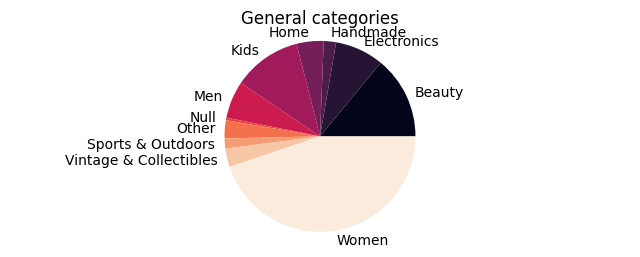

In [38]:
plt.figure(figsize = (8,6))
cmap = cm.get_cmap('rocket')

plt.subplot(2, 1, 1)
train.name.groupby(train.general_cat).count().plot(kind = 'pie', colormap=cmap)
plt.title ('General categories')
plt.axis('equal')
plt.ylabel('')


<Axes: xlabel='general_cat'>

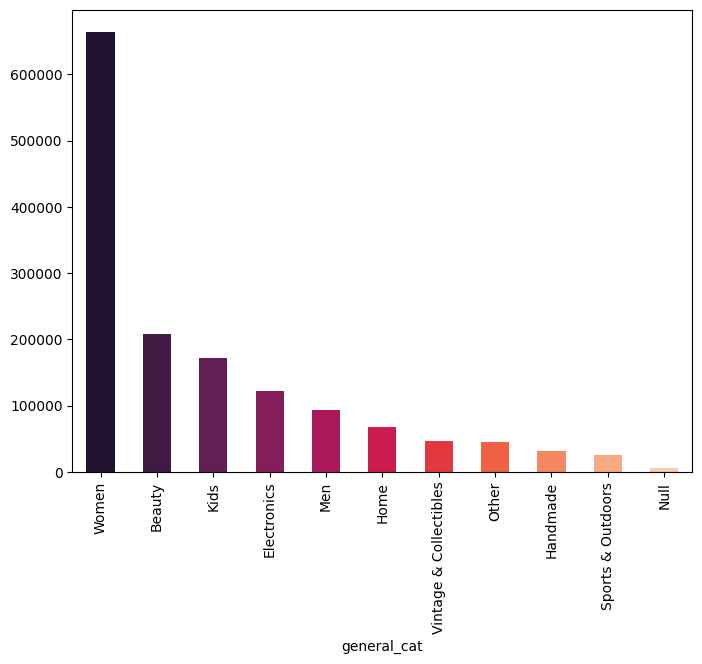

In [39]:
plt.figure(figsize = (8,6))
palette = sns.color_palette("rocket", len(train['general_cat'].value_counts()))
train['general_cat'].value_counts().plot(kind='bar', color=palette)

<ipython-input-40-efed81442059>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=train,x='general_cat', y=np.log(train.price+1), palette="rocket")
<ipython-input-40-efed81442059>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


[Text(0, 0, 'Men'),
 Text(1, 0, 'Electronics'),
 Text(2, 0, 'Women'),
 Text(3, 0, 'Home'),
 Text(4, 0, 'Sports & Outdoors'),
 Text(5, 0, 'Vintage & Collectibles'),
 Text(6, 0, 'Beauty'),
 Text(7, 0, 'Other'),
 Text(8, 0, 'Kids'),
 Text(9, 0, 'Null'),
 Text(10, 0, 'Handmade')]

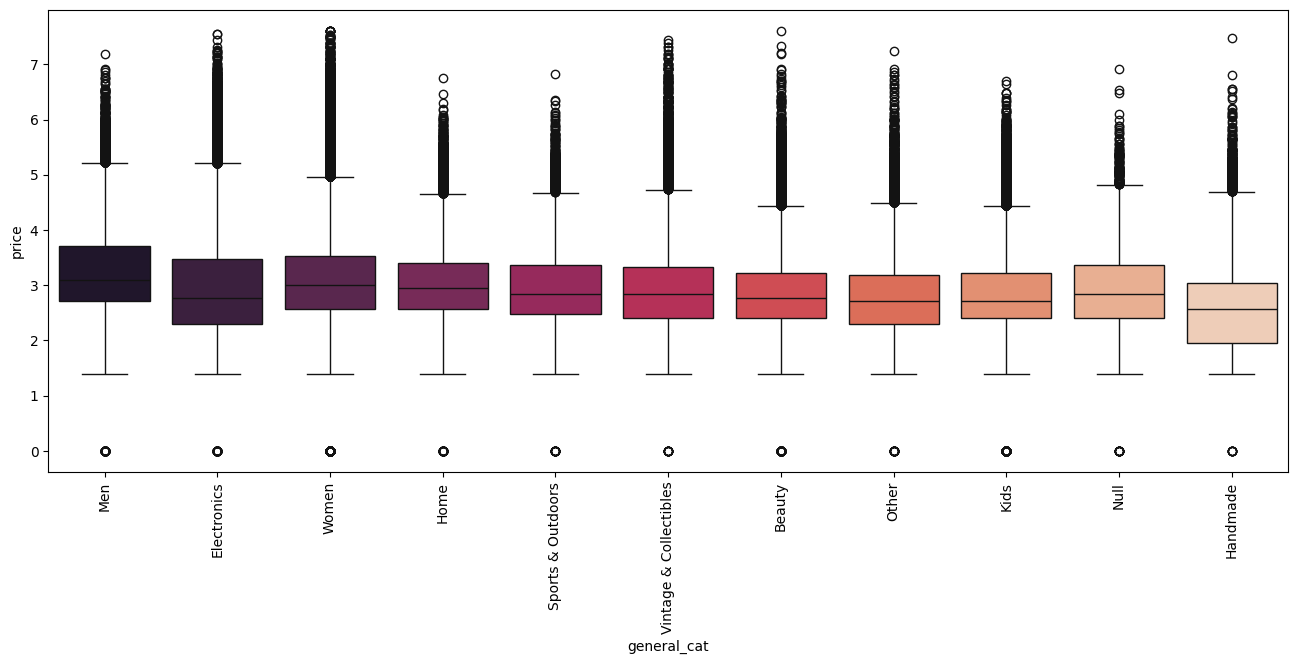

In [40]:
# Box Plot for Price by Category Level
plt.figure(figsize = (16,6))
ax = sns.boxplot(data=train,x='general_cat', y=np.log(train.price+1), palette="rocket")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

The box plot shows that categories like Electronics and Vintage & Collectibles have a wide price range, while Beauty and Handmade exhibit more consistent pricing with fewer outliers.

#### 2.2.1.b) Analysis of 2 Sub Categories

Text(0.5, 1.0, 'Bottom 10 Subcategories')

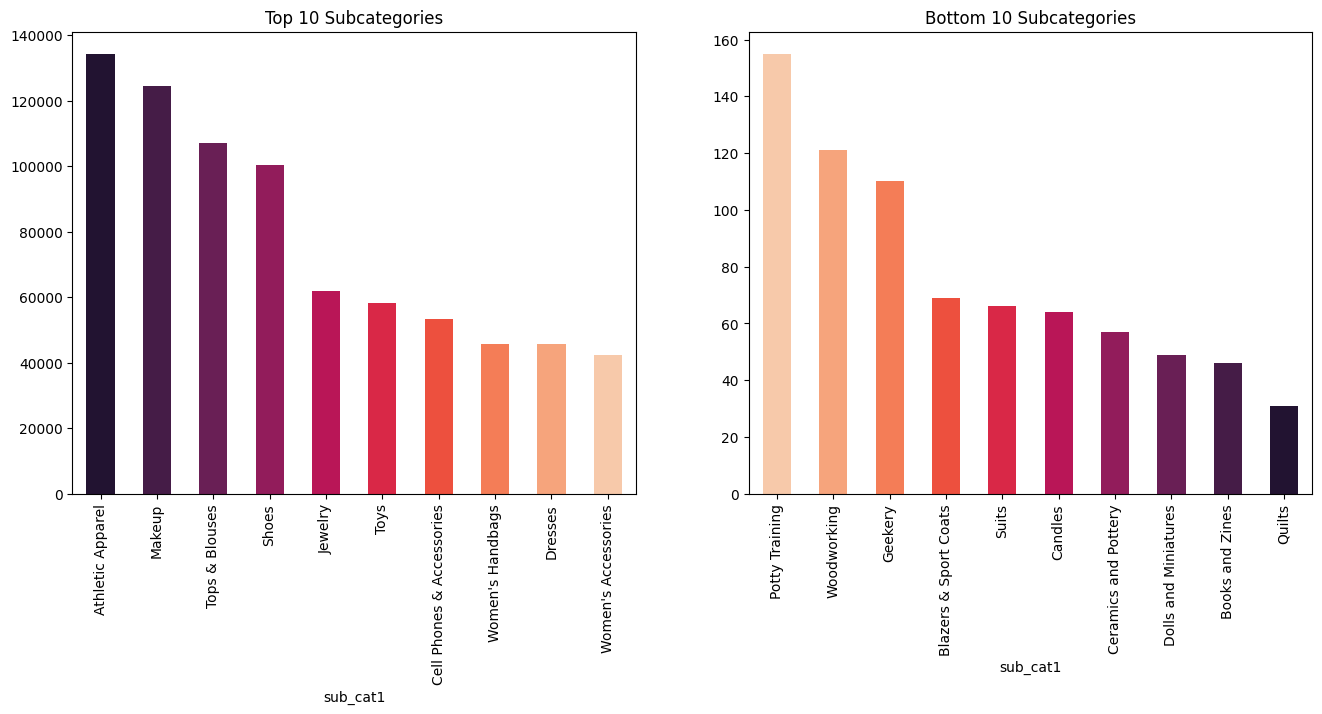

In [41]:
plt.figure(figsize=(16, 6))
colors_top = sns.color_palette("rocket", 10)
colors_bottom = sns.color_palette("rocket_r", 10)

# Plot the top 10 sub-categories
plt.subplot(1, 2, 1)
train.sub_cat1.value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color=colors_top)
plt.title('Top 10 Subcategories')

# Plot the bottom 10 sub-categories
plt.subplot(1, 2, 2)
train.sub_cat1.value_counts().sort_values(ascending=False)[-10:].plot(kind='bar', color=colors_bottom)
plt.title('Bottom 10 Subcategories')

The bar plots reveal that the Top 10 sub-categories are dominated by a few popular categories, while the Bottom 10 sub-categories show relatively lower product counts, indicating niche or less popular product types.

<ipython-input-42-97363a900319>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_luxury', data=train, palette='rocket')


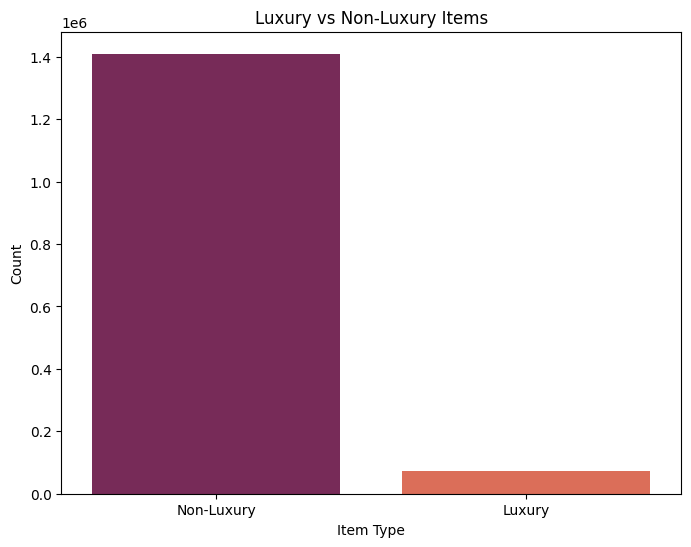

In [42]:
#  Luxury vs Non-Luxury Items
luxury_threshold = train['price'].quantile(0.95)
train['is_luxury'] = train['price'] > luxury_threshold

plt.figure(figsize=(8, 6))
sns.countplot(x='is_luxury', data=train, palette='rocket')
plt.title('Luxury vs Non-Luxury Items')
plt.xticks([0, 1], ['Non-Luxury', 'Luxury'])
plt.xlabel('Item Type')
plt.ylabel('Count')
plt.show()

### --- 2.3) Brand Analysis ---


<ipython-input-43-758d436d7179>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=top_brands['brand_name'], order=top_brands['brand_name'].value_counts().iloc[:10].index, palette='rocket')


Text(0.5, 0, 'Number of product of the brand')

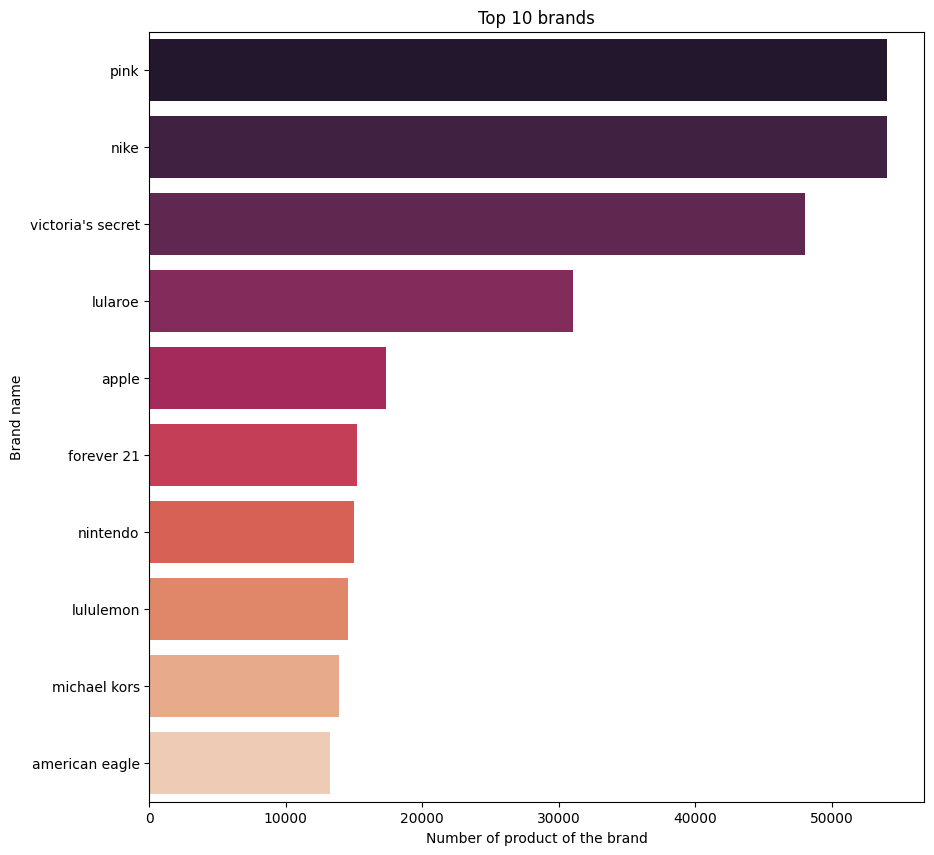

In [43]:
# Filtering out rows with 'Null' in the 'brand_name' column
top_brands = train[train['brand_name'] != "null"]

plt.figure(figsize=(10,10))
sns.countplot(y=top_brands['brand_name'], order=top_brands['brand_name'].value_counts().iloc[:10].index, palette='rocket')
plt.title('Top 10 brands')
plt.ylabel('Brand name')
plt.xlabel('Number of product of the brand')

The count plot shows that Pink is the top brand, with the highest number of products in the dataset, highlighting its popularity in the marketplace.

<ipython-input-44-4411ebf02662>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'price', y = 'brand_name', data = ranking, orient = 'h', palette='rocket')


Text(0.5, 0, 'Mean price')

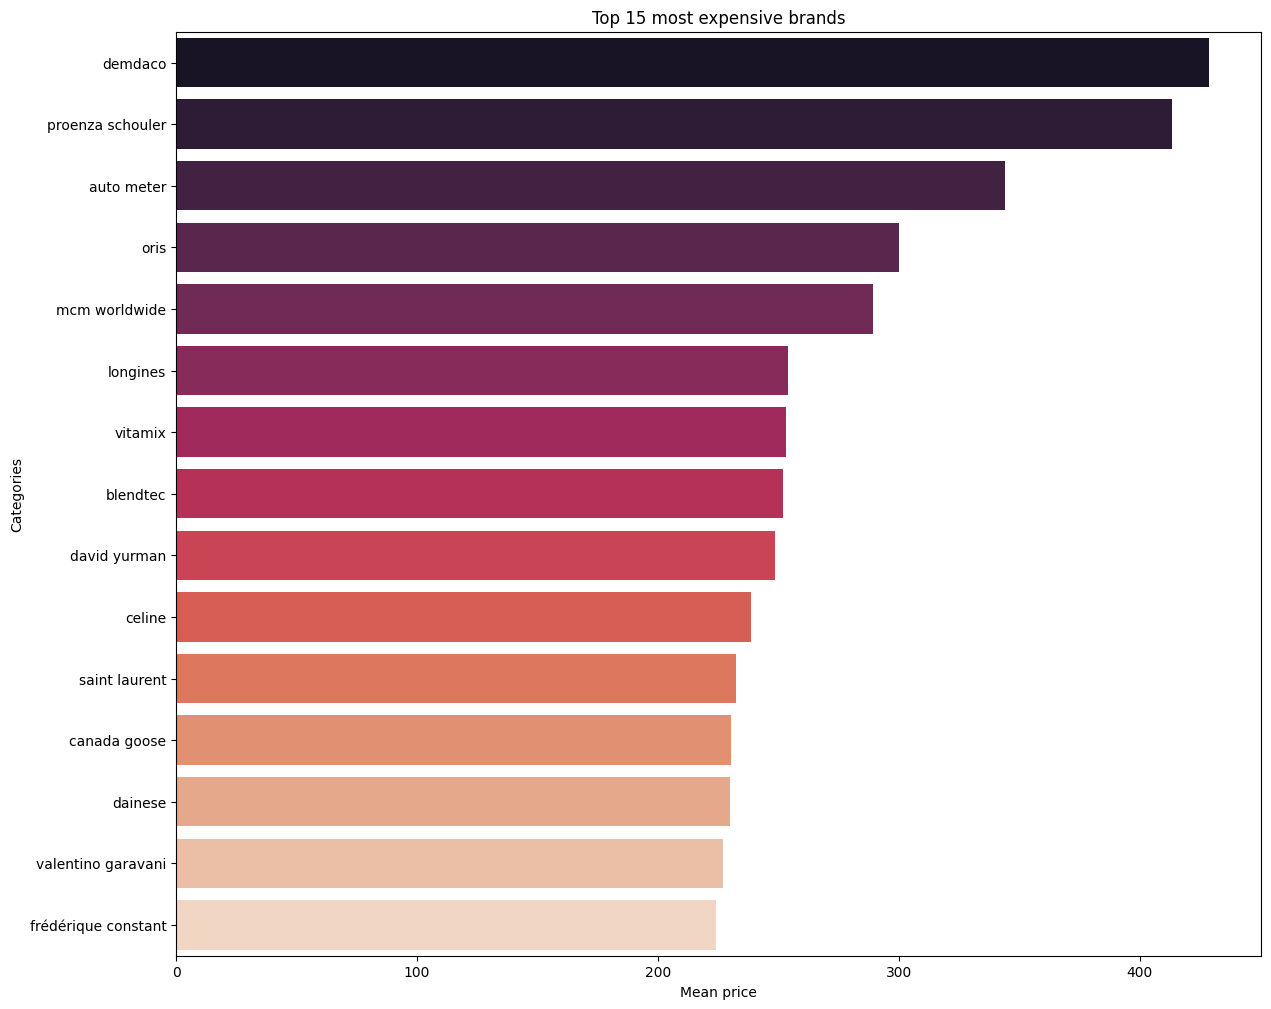

In [44]:
# Most expensive brand
group = train.groupby (train.brand_name)
ranking = pd.DataFrame(group.price.mean())
ranking.reset_index(level = 0, inplace=True)
ranking = ranking.sort_values(by='price', ascending = False).head(15)

plt.figure(figsize=(14,12))
sns.barplot(x = 'price', y = 'brand_name', data = ranking, orient = 'h', palette='rocket')
plt.title('Top 15 most expensive brands')
plt.ylabel('Categories')
plt.xlabel('Mean price')

###  --- 2.4) Price Distribution Analysis ---

In [45]:
#Eda for price
pd.options.display.float_format = '{:.2f}'.format
train.price.describe()

,price
count,1482535.00
mean,26.74
std,38.59
min,0.00
25%,10.00
50%,17.00
75%,29.00
max,2009.00


Text(0.5, 1.0, 'Simple distribution plot of the price')

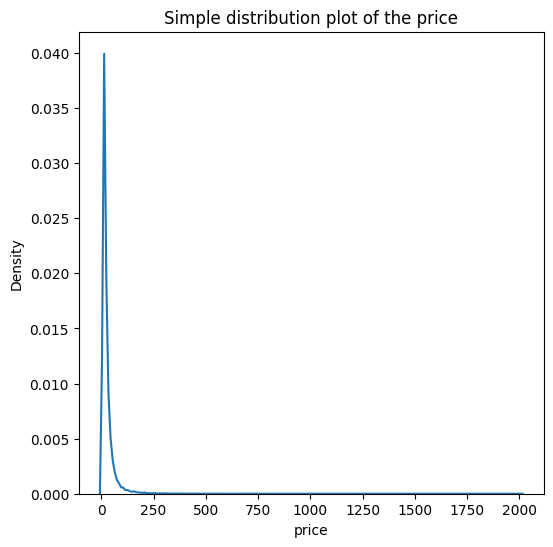

In [46]:
plt.figure(figsize=(6,6))
sns.kdeplot(train.price)
plt.title('Simple distribution plot of the price') #Most of items have a low price

The distribution plot shows that most items are priced on the lower end, indicating a skew towards affordable products in the dataset.

 ### --- 2.5) Shipping Analysis ---

<ipython-input-47-2d5a056654d5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='shipping', y='price', data=train, palette='rocket', showfliers=False)


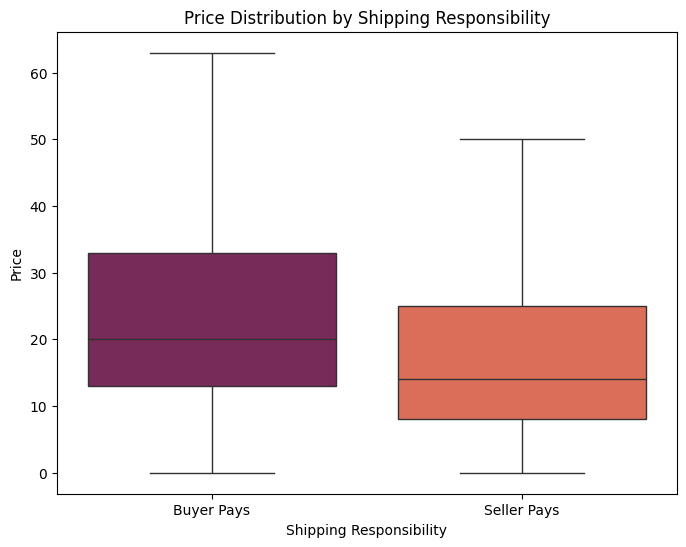

In [47]:
# Price by Shipping Responsibility
plt.figure(figsize=(8, 6))
sns.boxplot(x='shipping', y='price', data=train, palette='rocket', showfliers=False)
plt.title('Price Distribution by Shipping Responsibility')
plt.xticks([0, 1], ['Buyer Pays', 'Seller Pays'])
plt.xlabel('Shipping Responsibility')
plt.ylabel('Price')
#plt.yscale('log')  # Log scale to capture wide price range
plt.show()

The box plot reveals that sellers tend to pay shipping fees more frequently for higher-priced items. Additionally, the presence of outliers suggests that some expensive items have significantly higher prices compared to the majority, which flattens the distribution of the graph.

###  --- 2.6) Item Description Analysis ---

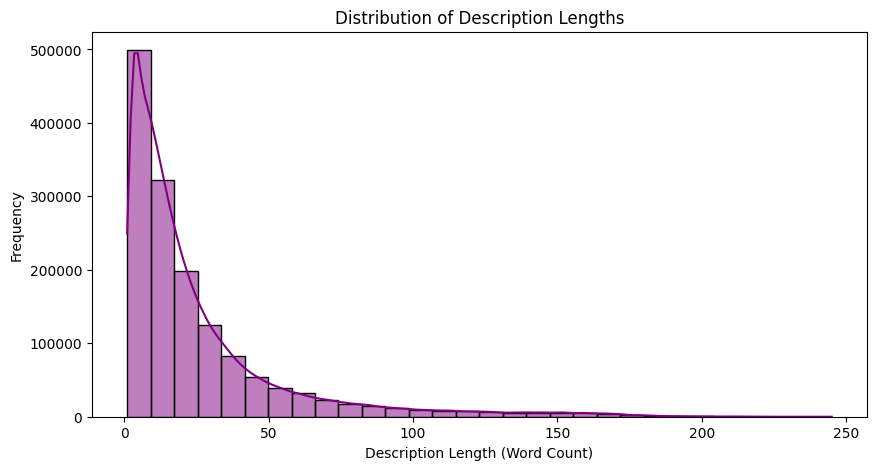

In [48]:
train['desc_length'] = train['item_description'].apply(lambda x: len(str(x).split()))
#Plot distribution of description length
plt.figure(figsize=(10, 5))
sns.histplot(train['desc_length'], bins=30, kde=True, color="purple")
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length (Word Count)')
plt.ylabel('Frequency')
plt.show()

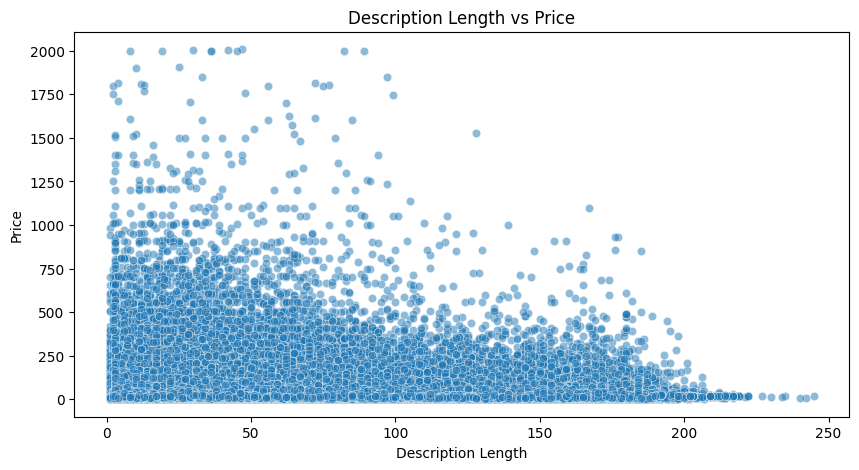

In [49]:
#Correlation between description length and price
plt.figure(figsize=(10, 5))
sns.scatterplot(data=train, x='desc_length', y='price', alpha=0.5)
plt.title('Description Length vs Price')
plt.xlabel('Description Length')
plt.ylabel('Price')
plt.show()

Upon a closer look, the scatter plot seems to show that as the description length increases, the price also tends to increase, though the relationship isn't strictly linear. There is a general trend where longer descriptions seem to correspond to higher prices, especially as you move to the right side of the plot (with higher description lengths). This could indicate that products with longer descriptions are generally more expensive, but the data also has significant spread, so there might be other factors influencing the price as well.

### --- 2.7) Correlation Heatmap ---

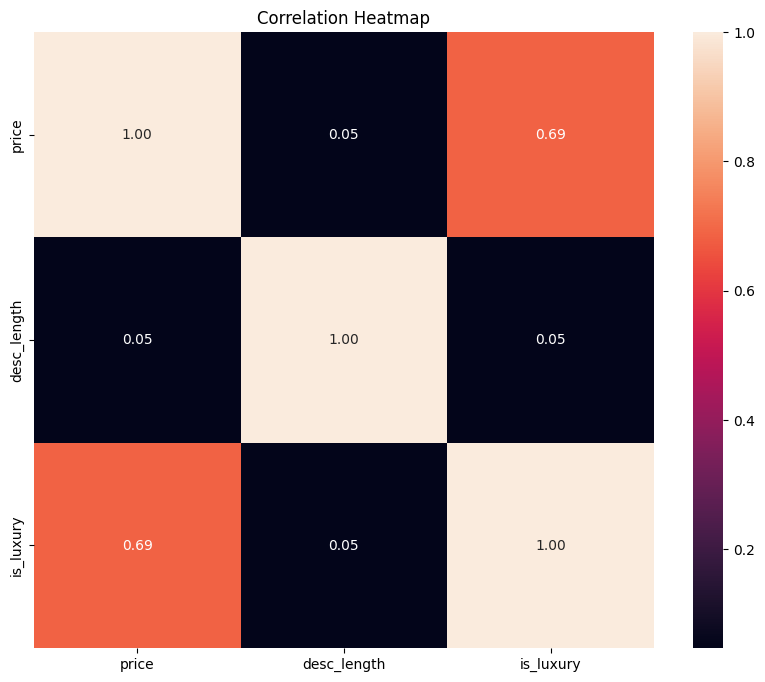

In [50]:
plt.figure(figsize=(10, 8))
corr_matrix = train[['price', 'desc_length', 'is_luxury']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='rocket', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## 3.) Hypothesis Testing

In [51]:
import scipy.stats as stats

# Split data into two groups based on shipping responsibility
buyer_pays = train[train['shipping'] == 0]['price']
seller_pays = train[train['shipping'] == 1]['price']

# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(buyer_pays, seller_pays, equal_var=False)  # Use Welch's t-test (unequal variance)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the Null Hypothesis: There is a significant difference in the mean prices based on shipping responsibility.")
else:
    print("Fail to Reject the Null Hypothesis: There is no significant difference in the mean prices based on shipping responsibility.")


T-statistic: 119.77499916636837
P-value: 0.0
Reject the Null Hypothesis: There is a significant difference in the mean prices based on shipping responsibility.


## 4.) Models Training


In this section, categorical features such as category_name, brand_name, and subcategories are encoded using label encoding. New features, like the length of item descriptions and names, are also created. The dataset is split into categorical and numerical features, and several baseline regression models (Linear Regression, Ridge, Decision Tree) are trained. The models' performance is evaluated using metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), R², and Explained Variance. The results of these models are then summarized and displayed for comparison.

### 4.1) Baseline Models

In [52]:
# Encode categorical features into numerical values using category codes
train['general_cat_encoded'] = train['category_name'].astype('category').cat.codes
train['brand_encoded'] = train['brand_name'].astype('category').cat.codes
train['sub_cat1_encoded'] = train['sub_cat1'].astype('category').cat.codes
train['sub_cat2_encoded'] = train['sub_cat2'].astype('category').cat.codes

In [53]:
# Calculate the length of item descriptions and names, storing in new columns
train['desc_len'] = train['item_description'].apply(len)
train['name_len'] = train['name'].apply(len)

In [54]:
train_model1 = train.copy()

In [55]:
# Function to get categorical features based on unique values count
def get_categorical_features(df, nunique_threshold=30):
    all_df_columns = df.columns
    categorical_features = [col for col in all_df_columns if df[col].nunique() < nunique_threshold]
    return categorical_features

# Function to get numerical features based on unique values count
def get_numerical_features(df, nunique_threshold=30):
    numerical_df_columns = df.select_dtypes(include=[np.number]).columns
    numerical_features   = [col for col in numerical_df_columns if df[col].nunique() >= nunique_threshold]
    return numerical_features

In [56]:
from sklearn.preprocessing import LabelEncoder

# Function to encode categorical string features using LabelEncoder
def encode_str_features(df):
    categorical_features = get_categorical_features(df.select_dtypes(exclude=[np.number]))
    label_encoder = LabelEncoder()
    for col in categorical_features:
        df[col] = label_encoder.fit_transform(df[col])

In [57]:
encode_str_features(train_model1)

In [58]:
train_model1.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'item_description_clean',
       'clean_category_name', 'target_log', 'cat_split_count', 'general_cat',
       'sub_cat1', 'sub_cat2', 'is_luxury', 'desc_length',
       'general_cat_encoded', 'brand_encoded', 'sub_cat1_encoded',
       'sub_cat2_encoded', 'desc_len', 'name_len'],
      dtype='object')

In [59]:
# Define the features and target for model training
features = ['item_condition_id', 'shipping', 'general_cat_encoded', 'brand_encoded', 'sub_cat1_encoded', 'sub_cat2_encoded', 'desc_len', 'name_len']
X = train_model1[features]
y = np.log1p(train_model1['price'])

In [60]:
# Initialize baseline models for training
from sklearn.linear_model    import LinearRegression, Ridge
from sklearn.tree            import DecisionTreeRegressor

baseline_models = {
    'LinearRegression':          LinearRegression(),
    'Ridge':                     Ridge(),
    'DecisionTreeRegressor':     DecisionTreeRegressor(),
}

In [61]:
# Function to evaluate model performance using multiple metrics
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    ev  = explained_variance_score(y_test, y_pred)

    result = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'R^2': r2,
        'Explained Variance': ev,
    }
    return result

# Function to train and evaluate multiple models
def run_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        print(f'Model {name} ...')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = evaluate_model(y_test, y_pred)
    results = pd.DataFrame(results).T
    results = results.reset_index()
    results = results.rename(columns={'index': 'Model'})
    return results

In [62]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models_result1 = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression ...
Model Ridge ...
Model DecisionTreeRegressor ...


In [63]:
models_result1

,Model,Mean Absolute Error,Mean Squared Error,R^2,Explained Variance
0,LinearRegression,0.56,0.52,0.07,0.07
1,Ridge,0.56,0.52,0.07,0.07
2,DecisionTreeRegressor,0.56,0.59,-0.05,-0.05


#### 4.1.1) Hyperparmeter Tuning

In this step, we manually tune key hyperparameters of the Decision Tree Regressor, such as max_depth, min_samples_split, and min_samples_leaf. By iteratively adjusting these parameters and evaluating the model's performance, we aim to find an optimal balance between model complexity and predictive accuracy. This approach is computationally efficient and allows for fine control over the tuning process.

In [64]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split data (if not already split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and optimize Decision Tree Regressor
dt_model = DecisionTreeRegressor(
    max_depth=10,                # Limit tree depth
    min_samples_split=100,       # Minimum samples required to split a node
    min_samples_leaf=50,         # Minimum samples required at leaf node
    max_features='sqrt',         # Use the best subset of features
    random_state=42,             # Ensure reproducibility
    max_leaf_nodes=1000         # Limit the number of leaf nodes
)

# Fit the model on the training data
dt_model.fit(X_train, y_train)

# Predict and evaluate on test data
y_pred_dt = dt_model.predict(X_test)

In [65]:
results_dt = evaluate_model(y_test, y_pred_dt)
results_dt

{'Mean Absolute Error': 0.5012224284609372,
 'Mean Squared Error': 0.4272050921285189,
 'R^2': 0.24268720381017395,
 'Explained Variance': 0.24269842181423562}

Hyperparameter tuning significantly improved the performance of the Decision Tree Regressor. The Mean Absolute Error (MAE) decreased from 0.56 to 0.50, and the Mean Squared Error (MSE) dropped from 0.59 to 0.43, indicating better predictive accuracy. <br> <br> Additionally, the R² score improved from -0.05 (no predictive power) to 0.24, showing the model now explains 24% of the variance in the target variable. This highlights the importance of optimizing hyperparameters to reduce overfitting and enhance generalization.

### 4.2) Advance Model

LightGBM is a powerful gradient boosting framework designed for efficiency and scalability, making it ideal for large datasets. <br><br> After exploring simpler models like Linear Regression, Ridge, and Decision Tree, we move to LightGBM to better capture non-linear relationships and interactions between features while maintaining computational efficiency. <br><br> The model's hyperparameters, such as num_leaves, learning_rate, and n_estimators, are carefully chosen to balance performance and training speed. LightGBM’s histogram-based algorithm ensures faster training and lower memory usage compared to traditional gradient boosting methods.

In [66]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Sample 20% of the data for training to speed up the process
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)

# Initialize LightGBM Regressor
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    metric='mse',  # Mean Squared Error
    num_leaves=31,  # Control overfitting (default value)
    learning_rate=0.05,  # Learning rate
    n_estimators=100,  # Number of trees (can be adjusted for speed vs. accuracy)
    n_jobs=-1,  # Use all cores
    random_state=42
)

# Train LightGBM model on sampled data
lgb_model.fit(X_sample, y_sample)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1129
[LightGBM] [Info] Number of data points in the train set: 237205, number of used features: 8
[LightGBM] [Info] Start training from score 2.980049


In [67]:
results_dt = evaluate_model(y_test, y_pred_lgb)
results_dt

{'Mean Absolute Error': 0.4680288167329957,
 'Mean Squared Error': 0.37212846558546814,
 'R^2': 0.3403223556858277,
 'Explained Variance': 0.34032282860058594}

The LightGBM model achieved a MAE of 0.47 and MSE of 0.37, outperforming the Decision Tree Regressor in predictive accuracy. The R² score of 0.34 indicates that the model explains 34% of the variance in the target variable, reflecting its ability to capture complex relationships in the data more effectively.

### 4.3) Combining and Comparing the models

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

# Function to evaluate model performance using multiple metrics
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    ev  = explained_variance_score(y_test, y_pred)

    result = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'R^2': r2,
        'Explained Variance': ev,
    }
    return result

# Function to train and evaluate multiple models
def run_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        print(f'Model {name} ...')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = evaluate_model(y_test, y_pred)
    results = pd.DataFrame(results).T
    results = results.reset_index()
    results = results.rename(columns={'index': 'Model'})
    return results

# Function to plot learning curve for each model
def plot_learning_curves(models, X_train, y_train):
    plt.figure(figsize=(10, 8))

    # Loop through each model and plot its learning curve
    for name, model in models.items():
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
        )

        # Calculate mean and standard deviation for the train and test scores
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        # Plot the learning curve for each model
        plt.plot(train_sizes, train_mean, label=f'{name} (Train)', lw=2)
        plt.plot(train_sizes, test_mean, label=f'{name} (CV)', lw=2)
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
        plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    # Adding titles and labels
    plt.title('Learning Curves for Multiple Models', fontsize=16)
    plt.xlabel("Training Size", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

Model Linear Regression ...
Model Ridge Regression ...
Model Decision Tree ...
Model LightGBM ...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1128
[LightGBM] [Info] Number of data points in the train set: 593014, number of used features: 8
[LightGBM] [Info] Start training from score 2.979679


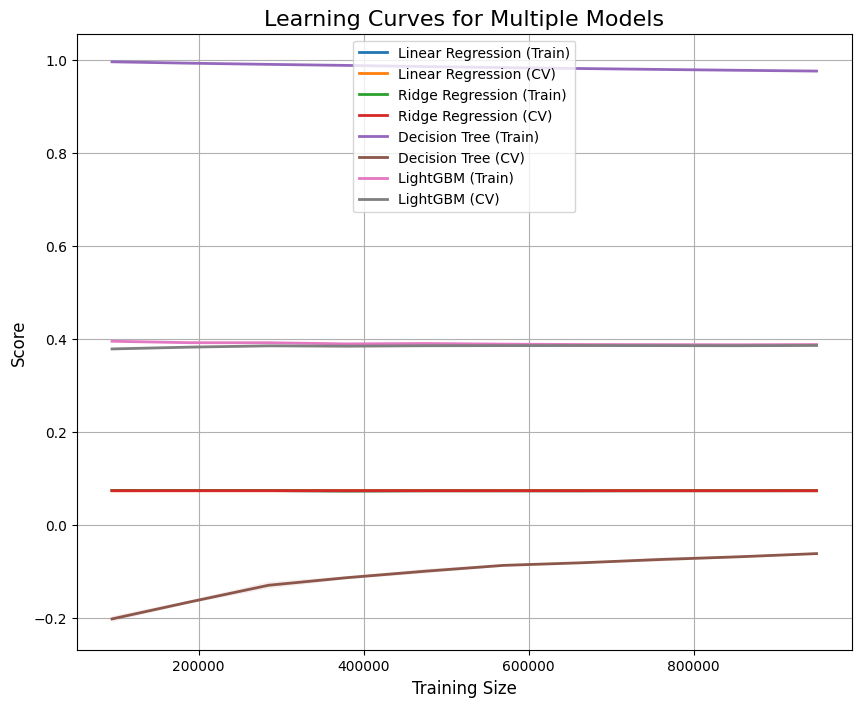

In [75]:
# Define your models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "LightGBM": lgb.LGBMRegressor()
}

# Assuming you have your training and test data ready:
# X_train, y_train, X_test, y_test are your data splits
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

# Run models and get results
model_results = run_models(models, X_train_sampled, X_test, y_train_sampled, y_test)  # Use sampled data


# Plot learning curves for each model
plot_learning_curves(models, X_train, y_train)

Insights:


*   The Decision Tree exhibits extreme overfitting, with perfect training score (~1.0) but negative cross-validation performance, showing the largest gap between training and validation curves.
* Linear Regression and Ridge Regression display nearly identical performance patterns with moderate scores, suggesting that the L2 regularization in Ridge isn't providing significant benefits.
* LightGBM demonstrates the most balanced and stable performance, with both training and cross-validation scores consistently around 0.4 and minimal gap between the curves.
* All models show relatively flat learning curves after initial iterations, indicating early convergence, except for the Decision Tree's CV score which gradually improves but remains poor.




### Conclusion

In this project, we aimed to optimize pricing prediction for products listed on the Mercari marketplace. Through extensive exploratory data analysis (EDA), we identified key features and relationships that influenced pricing. After evaluating simpler models like Linear Regression, Ridge, and Decision Tree Regressor, we observed significant improvements through hyperparameter tuning. The Decision Tree model’s performance was enhanced, reducing error metrics like MAE and MSE. However, LightGBM outperformed all other models, achieving a notable increase in R², demonstrating its ability to capture complex patterns in the data. This work highlights the value of EDA in feature selection and the superior performance of advanced models like LightGBM for large datasets and non-linear relationships.